# Trabajo Práctico Nº 2 - Entrenamiento y evaluación de modelos

In [1]:
%matplotlib inline
from itertools import product
from keras.layers import Dense, Activation, Input, Dropout
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/home/abarsotti/Programming/VirtualEnv/MachineLearning/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Parámetros para los gráficos.
plt.rcParams['figure.figsize'] = 16, 5
TITLE_FONTSIZE = 18
LABEL_FONTSIZE = 12

In [3]:
# Semilla
TRAIN_SEED = 47
SPLIT_SEED = 27

In [4]:
# Cargar dataset.
dataset = pd.read_csv('data/diamonds.csv', index_col=0)

## Preprocesado

Etiquetamos las instancias según el rango de precio al que pertenezcan.

In [5]:
price_category_labels = [
    'Menor a 1000', 
    'Entre 1000 y 3000', 
    'Entre 3000 y 6000', 
    'Entre 6000 y 10000', 
    'Mayor a 10000'
]
price_limits = [0, 1000, 3000, 6000, 10000, 20000]

dataset['price_category'] = pd.cut(dataset.price, price_limits, labels=price_category_labels).astype(str)

In [6]:
# 60% train, 20% test, 20% validation
train, not_train = train_test_split(dataset, test_size=0.4, random_state=SPLIT_SEED)
validation, test = train_test_split(not_train, test_size=0.5, random_state=SPLIT_SEED)

In [7]:
sets = [('Train', train), ('Test', test), ('Validation', validation)]

In [8]:
def evaluate_model(model, extract_inputs_function, extract_outputs_function):
    for set_name, set_data in sets:
        inputs = extract_inputs_function(set_data)
        outputs = extract_outputs_function(set_data)
        predictions = model.predict(inputs)
        
        if isinstance(model, Sequential):
            dataset = set_data.copy()
            for label_index, label in enumerate(price_category_labels):
                dataset[label] = predictions[:, label_index]

            predictions = dataset[price_category_labels].idxmax(axis=1)

        print(f'{set_name:-^115}')
        print(f'Accuracy: {accuracy_score(outputs, predictions):.5f}')
        print(f'Precision: {precision_score(outputs, predictions, average="macro"):.5f}')
        print(f'Recall: {recall_score(outputs, predictions, average="macro"):.5f}')

        # Mostrar matriz de confusión y matriz de confusión normalizada.
        if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier)):
            cm = confusion_matrix(outputs, predictions)
        else:
            cm = confusion_matrix(outputs, predictions, labels=price_category_labels)
        # Normalizar
        n_cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        confusion_matrices = ((cm, 'Matriz de confusión', 'd'), (n_cm, 'Matriz de confusión normalizada', '.2f'))
        
        for index, (matrix, plot_title, number_format) in enumerate(confusion_matrices):
            plt.subplot(1, 2, index + 1)
        
            plt.imshow(
                matrix, 
                cmap=plt.cm.BuPu,
                interpolation='nearest',
            )

            plt.colorbar()
            
            thresh = matrix.max() / 2.
            for i, j in product(range(matrix.shape[0]), range(matrix.shape[1])):
                plt.text(j, i, format(matrix[i, j], number_format),
                         horizontalalignment="center",
                         color="white" if matrix[i, j] > thresh else "black")

            plt.xticks([x for x in range(len(price_category_labels))], price_category_labels, rotation=45)
            plt.yticks([x for x in range(len(price_category_labels))], price_category_labels)
            plt.xlabel('Clase predicha')
            plt.ylabel('Clase correcta')

            plt.title(plot_title)

        plt.show()

#### Balanceo de los datasets

In [9]:
balance_matrix = pd.DataFrame()
for set_name, set_data in [('Dataset', dataset), *sets]:
    balance_matrix[set_name] = (set_data.price_category.value_counts() / len(set_data) * 100)
balance_matrix.T

,Entre 1000 y 3000,Menor a 1000,Entre 3000 y 6000,Entre 6000 y 10000,Mayor a 10000
Dataset,29.314053,26.926214,22.345198,11.733407,9.681127
Train,29.069336,27.008404,22.389074,11.704363,9.828822
Test,30.181683,26.612903,22.080089,11.688914,9.436411
Validation,29.180571,26.992955,22.478680,11.865035,9.482759


## Modelos

### Regresión Logística

In [10]:
# Columnas de entrada para Regresión Logística.
ONE_HOT_ENCONDING_COLUMNS = ['cut', 'color', 'clarity']

LR_INPUT_COLUMNS = [
    'carat',
    'depth',
    'table',
    'x',
    'y',
    'z',
    'cut_Fair',
    'cut_Good',
    'cut_Ideal',
    'cut_Premium',
    'cut_Very Good',
    'color_D',
    'color_E',
    'color_F',
    'color_G',
    'color_H',
    'color_I',
    'color_J',
    'clarity_I1',
    'clarity_IF',
    'clarity_SI1',
    'clarity_SI2',
    'clarity_VS1',
    'clarity_VS2',
    'clarity_VVS1',
    'clarity_VVS2',
]


def lr_extract_inputs(dataset):
    inputs = pd.get_dummies(dataset, columns=ONE_HOT_ENCONDING_COLUMNS)
    
    return inputs[LR_INPUT_COLUMNS].values.astype(np.float64)

def lr_extract_outputs(dataset):
    return dataset.price_category.values

In [11]:
lr_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=TRAIN_SEED, multi_class='multinomial', solver='newton-cg')),
])

In [12]:
lr_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
);

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.90894
Precision: 0.90345
Recall: 0.90220


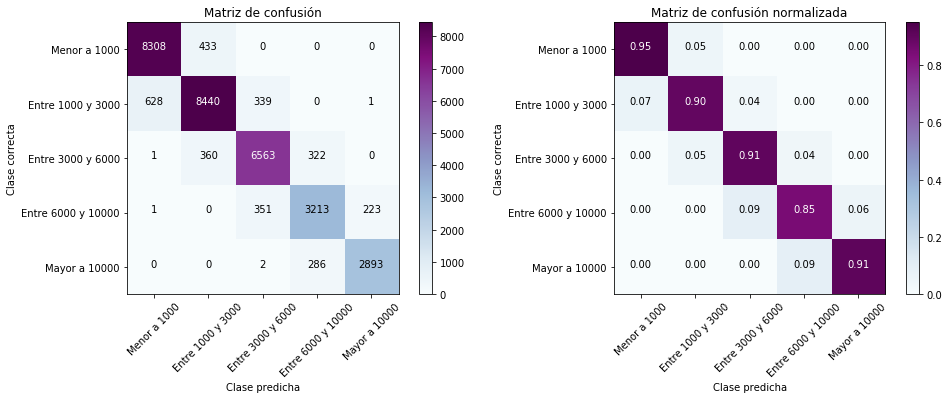

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.90527
Precision: 0.89706
Recall: 0.89815


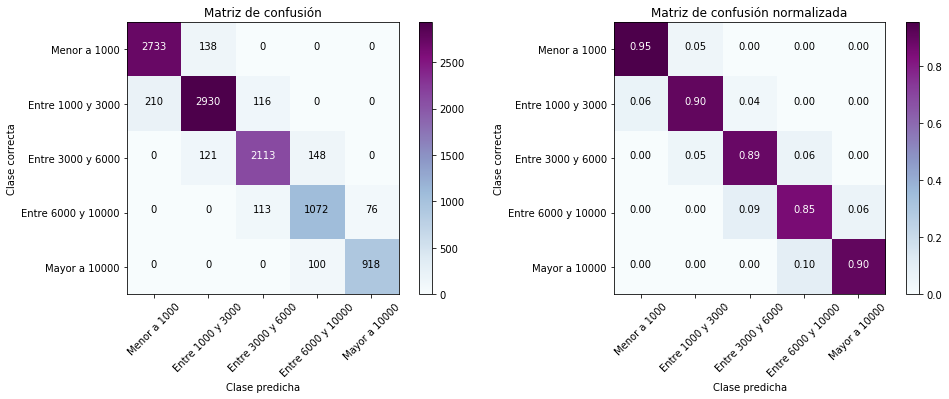

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.90925
Precision: 0.90206
Recall: 0.90166


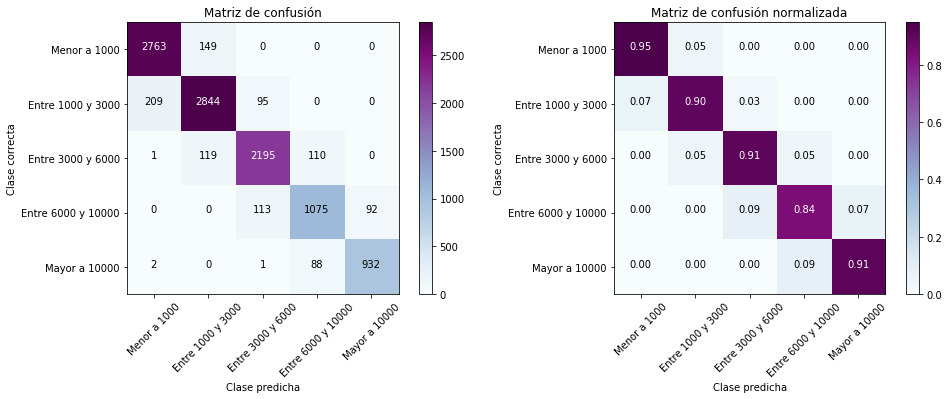

In [13]:
evaluate_model(lr_model, lr_extract_inputs, lr_extract_outputs)

In [14]:
clf = lr_model.steps[1][1]
for label, coefs in zip(clf.classes_.tolist(), clf.coef_.tolist()):
    print(label)
    for column, coef in zip(LR_INPUT_COLUMNS, coefs):
        print(f'    - {column}: {coef}')
    print()

Entre 1000 y 3000
    - carat: -9.001544531926505
    - depth: -0.11995936363822318
    - table: 0.09320536068279033
    - x: -2.0834864678547693
    - y: -1.887851942870183
    - z: 0.3425665777885486
    - cut_Fair: 0.357736749443288
    - cut_Good: 0.07981859464038042
    - cut_Ideal: -0.35234565568469767
    - cut_Premium: 0.2952505361037426
    - cut_Very Good: -0.09511932353494407
    - color_D: -0.8511792006080618
    - color_E: -0.6479448278318862
    - color_F: -0.4259844882621177
    - color_G: -0.07567782080781787
    - color_H: 0.4582001889910026
    - color_I: 1.0144161227350512
    - color_J: 1.1406211240167663
    - clarity_I1: 1.3469741513926334
    - clarity_IF: -0.8628425120405008
    - clarity_SI1: 0.6617653236905485
    - clarity_SI2: 1.534537802572315
    - clarity_VS1: -0.6349046650654242
    - clarity_VS2: -0.28258357687726016
    - clarity_VVS1: -0.9885893360879221
    - clarity_VVS2: -0.9280842443376214

Entre 3000 y 6000
    - carat: 3.008453103797602
    - de

### K-NN

In [15]:
K = 4

knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier(n_neighbors=K)),
])

In [16]:
knn_model.fit(
    lr_extract_inputs(train),
    lr_extract_outputs(train),
);

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.90650
Precision: 0.90851
Recall: 0.88919


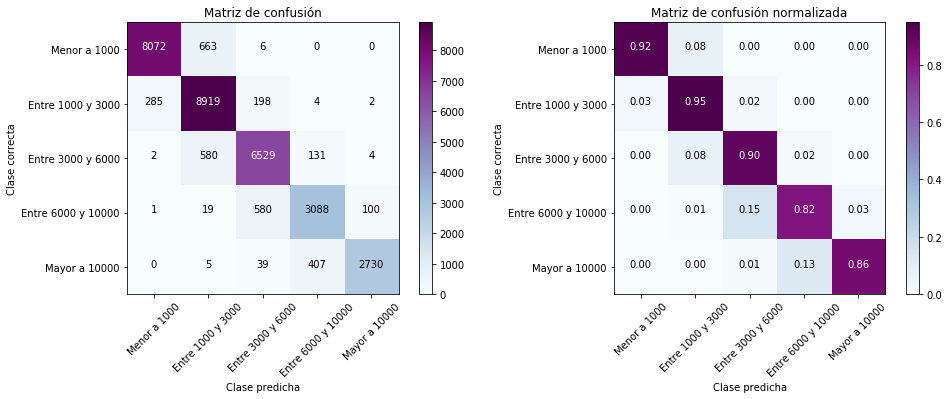

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.84844
Precision: 0.84833
Recall: 0.82527


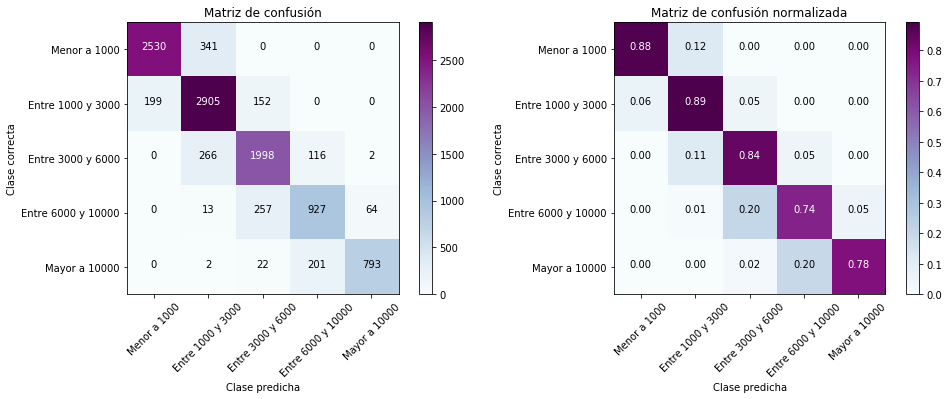

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.85067
Precision: 0.84875
Recall: 0.82798


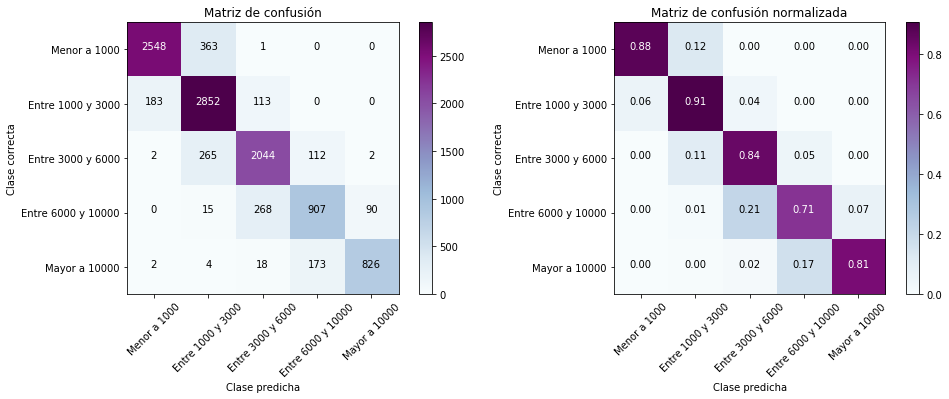

In [17]:
evaluate_model(knn_model, lr_extract_inputs, lr_extract_outputs)

### Árbol de Decisión

In [18]:
DT_INPUT_COLUMNS = [
    'carat',
    'cut',
    'color',
    'clarity',
    'depth',
    'table',
    'x',
    'y',
    'z',    
]

def dt_extract_inputs(dataset):
    inputs = dataset.copy()
    
    cut_map = {c: i + 1 for i, c in enumerate(sorted(inputs.cut.unique()))}
    color_map = {c: i + 1 for i, c in enumerate(sorted(inputs.color.unique()))}
    clarity_map = {c: i + 1 for i, c in enumerate(sorted(inputs.clarity.unique()))}
    
    inputs['cut'] = inputs.cut.map(cut_map)
    inputs['color'] = inputs.color.map(color_map)
    inputs['clarity'] = inputs.clarity.map(clarity_map)
    
    return inputs[DT_INPUT_COLUMNS].values

def dt_extract_outputs(dataset):
    outputs = dataset.copy()
    
    price_category_map = {pc: i + 1 for i, pc in enumerate(price_category_labels)}
    outputs['price_category'] = outputs.price_category.map(price_category_map)
    
    return outputs.price_category.values

In [19]:
dt_model = DecisionTreeClassifier(random_state=TRAIN_SEED)

In [20]:
dt_model.fit(
    dt_extract_inputs(train),
    dt_extract_outputs(train),
)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=47,
            splitter='best')

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.99981
Precision: 0.99986
Recall: 0.99984


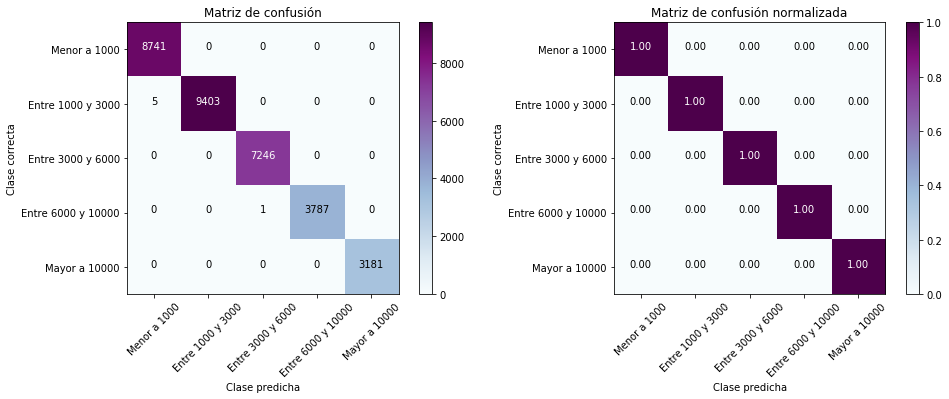

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.88830
Precision: 0.87733
Recall: 0.87731


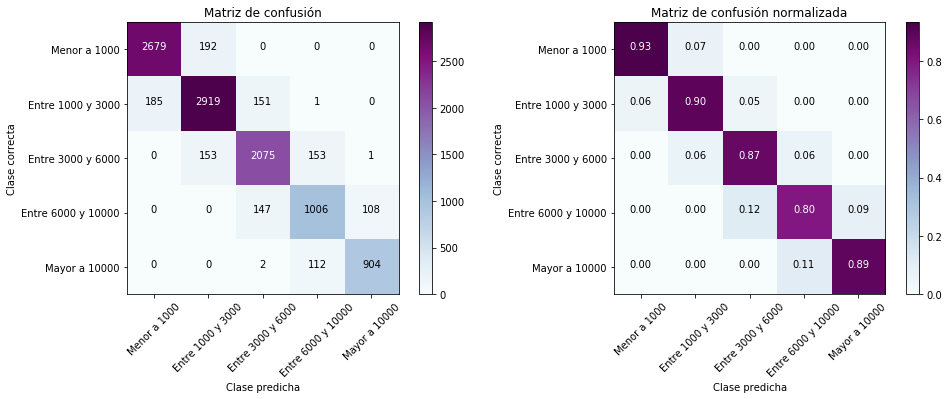

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.89516
Precision: 0.88336
Recall: 0.88403


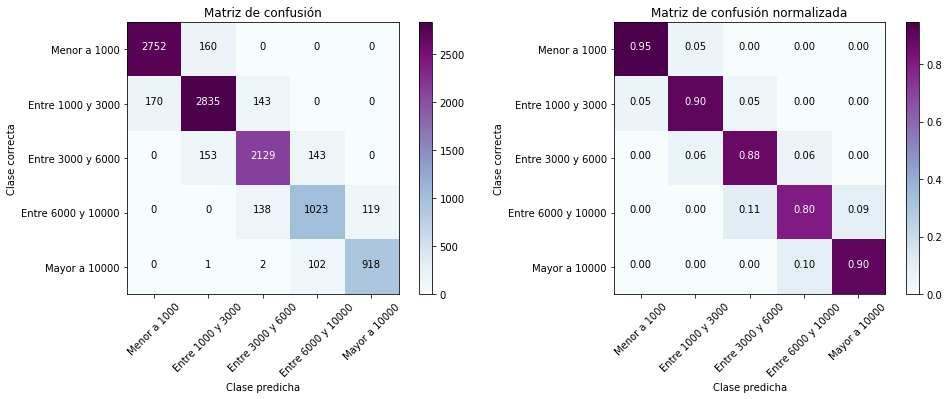

In [21]:
evaluate_model(dt_model, dt_extract_inputs, dt_extract_outputs)

### Random Forest

In [22]:
rf_model = RandomForestClassifier(
    n_estimators=30,
    max_features=4,
    random_state=TRAIN_SEED,
)

In [23]:
rf_model.fit(
    dt_extract_inputs(train),
    dt_extract_outputs(train),
);

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.99901
Precision: 0.99910
Recall: 0.99892


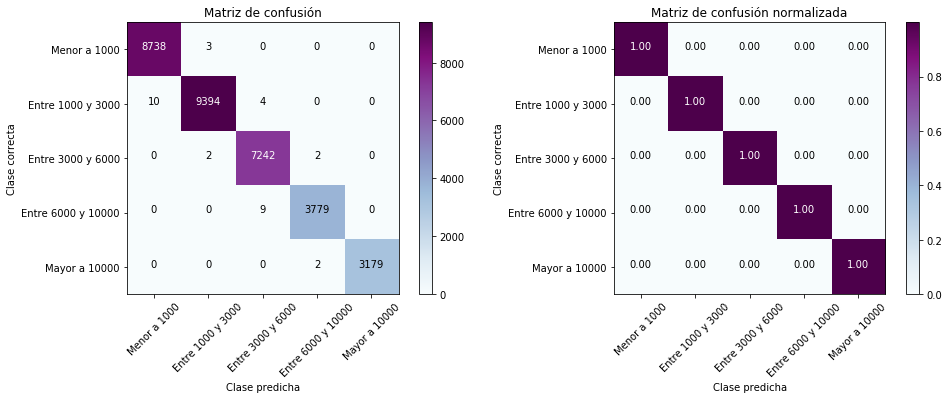

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.91898
Precision: 0.91196
Recall: 0.91331


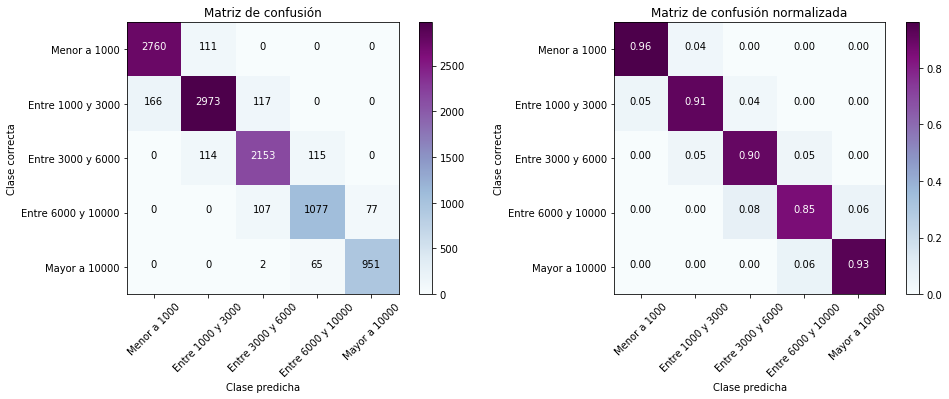

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.92232
Precision: 0.91527
Recall: 0.91537


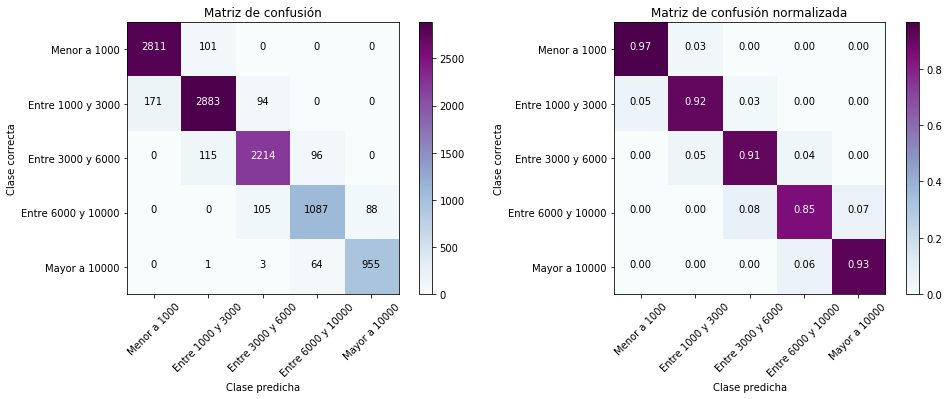

In [24]:
evaluate_model(rf_model, dt_extract_inputs, dt_extract_outputs)

### Gradient Boosting

In [25]:
gb_model = GradientBoostingClassifier(
    random_state=TRAIN_SEED,
    max_depth=10,
)

In [26]:
gb_model.fit(
    dt_extract_inputs(train),
    dt_extract_outputs(train),
);

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.99981
Precision: 0.99983
Recall: 0.99986


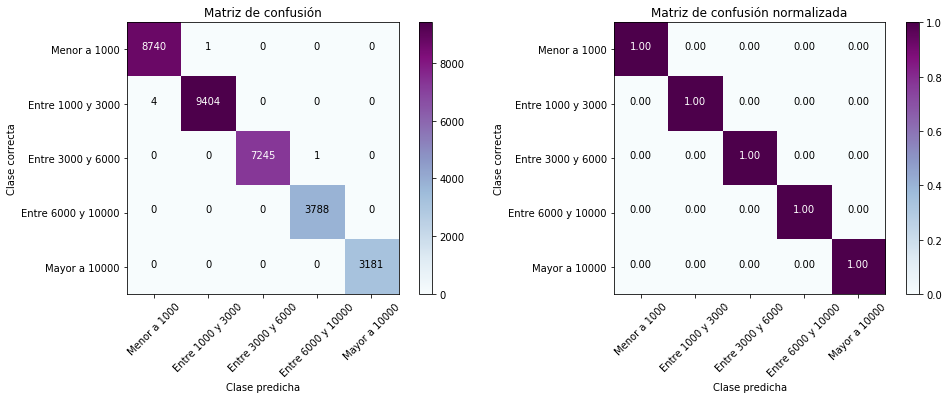

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.92102
Precision: 0.91187
Recall: 0.91351


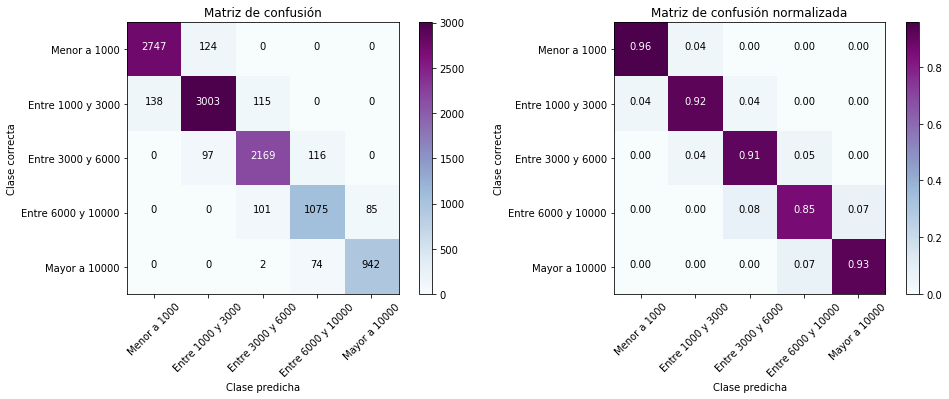

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.92204
Precision: 0.91282
Recall: 0.91519


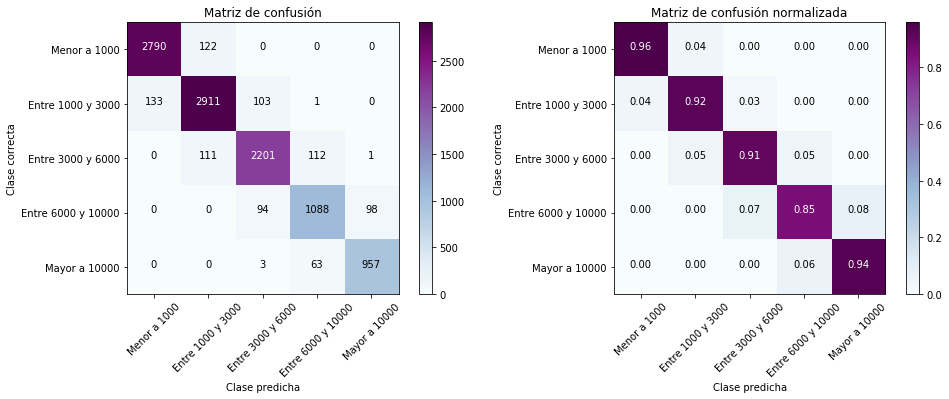

In [27]:
evaluate_model(gb_model, dt_extract_inputs, dt_extract_outputs)

### Red Neuronal

In [28]:
def nn_extract_outputs(dataset):
    #return dataset.price_category.values
    return pd.get_dummies(dataset.price_category)[price_category_labels].values.astype(np.float32)

In [29]:
nn_model = Sequential([   
    Dense(1000, input_shape=(len(LR_INPUT_COLUMNS), ), activation='tanh'),
    
    # Dropout(0.1),

    Dense(1000, activation='sigmoid'),
    
    Dense(1000, activation='tanh'),    
    
    Dense(1000, activation='sigmoid'),
        
    # Dropout(0.1),

    Dense(len(price_category_labels), activation='softmax'),
])

nn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy',],
)

In [30]:
history = nn_model.fit(
    lr_extract_inputs(train), 
    nn_extract_outputs(train),
    epochs=20,
    batch_size=256,
    validation_data=(
        lr_extract_inputs(test),
        nn_extract_outputs(test),
    )
)

Train on 32364 samples, validate on 10788 samples
Epoch 1/20
32364/32364 [==============================] - 2s 53us/step - loss: 1.0129 - acc: 0.5723 - val_loss: 0.3529 - val_acc: 0.8506
Epoch 2/20
32364/32364 [==============================] - 1s 33us/step - loss: 0.3749 - acc: 0.8398 - val_loss: 0.3540 - val_acc: 0.8475
Epoch 3/20
32364/32364 [==============================] - 1s 34us/step - loss: 0.3409 - acc: 0.8575 - val_loss: 0.3212 - val_acc: 0.8657
Epoch 4/20
32364/32364 [==============================] - 1s 33us/step - loss: 0.3304 - acc: 0.8618 - val_loss: 0.3004 - val_acc: 0.8724
Epoch 5/20
32364/32364 [==============================] - 1s 34us/step - loss: 0.2890 - acc: 0.8812 - val_loss: 0.3081 - val_acc: 0.8694
Epoch 6/20
32364/32364 [==============================] - 1s 33us/step - loss: 0.3138 - acc: 0.8667 - val_loss: 0.3131 - val_acc: 0.8652
Epoch 7/20
32364/32364 [==============================] - 1s 33us/step - loss: 0.2878 - acc: 0.8813 - val_loss: 0.2947 - val_acc

-------------------------------------------------------Train-------------------------------------------------------
Accuracy: 0.88422
Precision: 0.88529
Recall: 0.85992


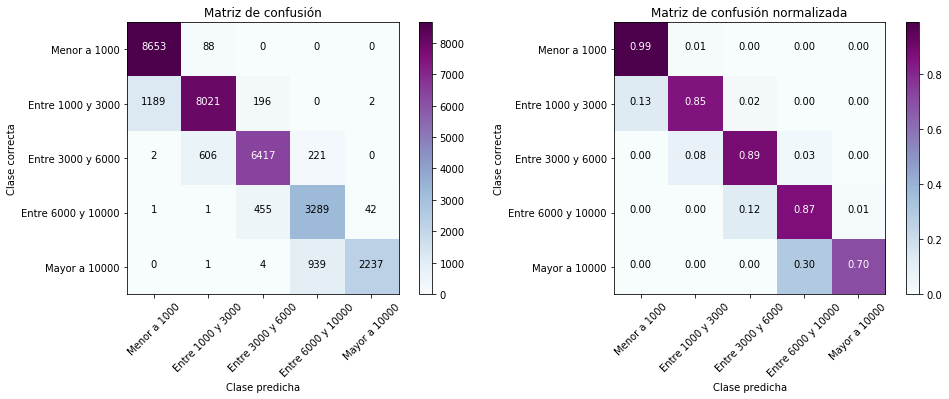

-------------------------------------------------------Test--------------------------------------------------------
Accuracy: 0.88459
Precision: 0.88736
Recall: 0.86362


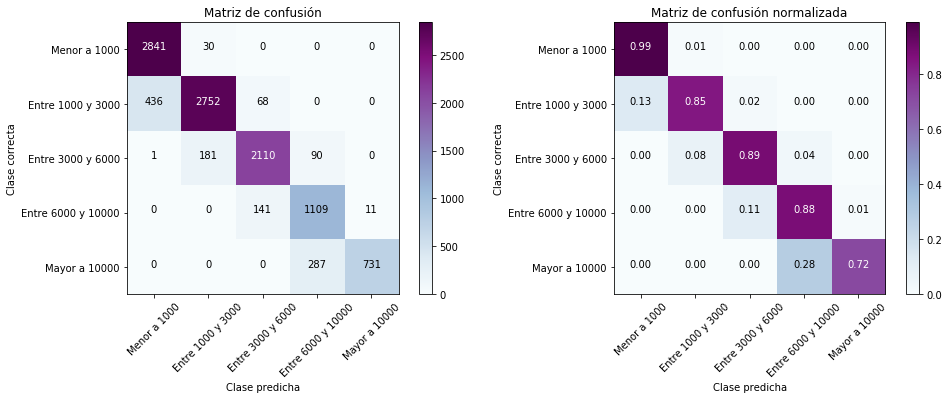

----------------------------------------------------Validation-----------------------------------------------------
Accuracy: 0.88487
Precision: 0.88675
Recall: 0.86259


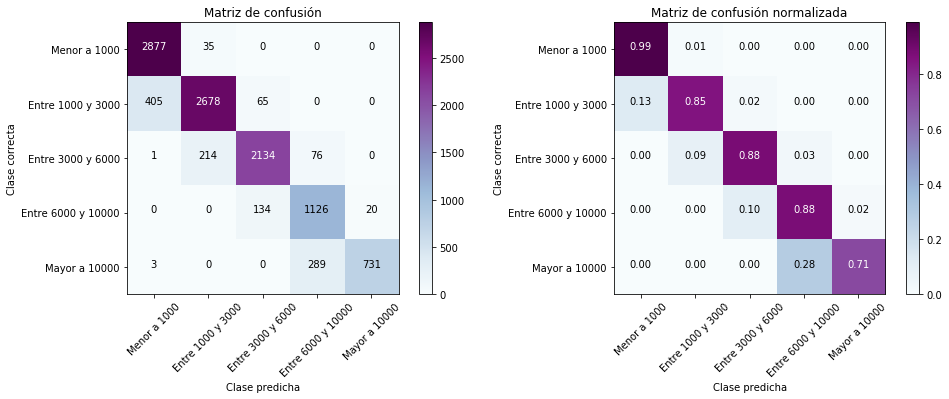

In [31]:
evaluate_model(nn_model, lr_extract_inputs, lr_extract_outputs)

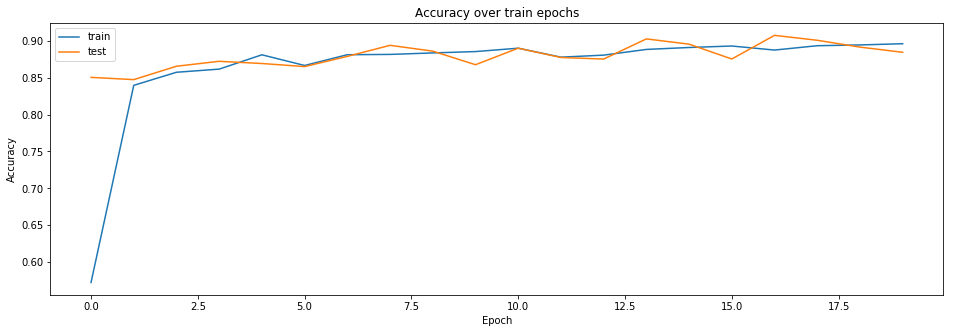

In [32]:
# plot accuracy over training epochs
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()